In [1]:
# !pip install torch==2.2
# !pip install torchvision
# !pip install seaborn
# !pip install numpy
# !pip install matplotlib
# !pip install torchsummary
# !pip install torchview
# !pip install graphviz
# !pip install torchviz
# !pip install pandas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import seaborn as sns
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
BATCH_SIZE = 64
num_epoch = 40
learning_rate = 1e-4
class_size = 10

INPUT_PATH = "/mnt/d/RESULTS/W4_X_s1/"
TRAIN_FILENAME_PREFIX = "QNN_TRAIN_CPU_cifar100_W4_X_"
TEST_FILENAME_PREFIX = "QNN_TEST_CPU_cifar100_W4_X_"

In [5]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.4),
                                      transforms.RandomRotation(30),
                                      # transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# transform_test = transforms.Compose([transforms.Resize((224, 224)),
#                                     #  transforms.ToTensor(),
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize((224, 224))])

In [6]:
train_start = 0
train_end = 50000

test_start = 0
test_end = 10000

def concat_parts(filename_prefix, end, step):
    q_train_images = np.load(INPUT_PATH + filename_prefix + "S0_E" + str(step) + "_s1.npy")
    for i in range(int(end / step) - 1):
        step_start = step * (i + 1)
        step_end = step_start + step
        q_train_images_part = np.load(INPUT_PATH + filename_prefix + "S" + str(step_start) + "_E" + str(step_end) + "_s1.npy")
        q_train_images = np.concatenate((q_train_images, q_train_images_part), axis=0)

    np.save(INPUT_PATH + filename_prefix + "S0_E" + str(end) + "_s1.npy", q_train_images)

In [7]:
# concat_parts(TRAIN_FILENAME_PREFIX, train_end, 1000)
# concat_parts(TEST_FILENAME_PREFIX, test_end, 5000)

q_train_images = np.load(INPUT_PATH + TRAIN_FILENAME_PREFIX + "S0_E" + str(train_end) + "_s1.npy")
q_test_images = np.load(INPUT_PATH + TEST_FILENAME_PREFIX + "S0_E" + str(test_end) + "_s1.npy")

In [8]:
torch.manual_seed(2024)

train = torchvision.datasets.CIFAR100("./data-cifar100/", train=True, download=True , transform=transforms.ToTensor())
test = torchvision.datasets.CIFAR100("./data-cifar100/", train=False, download=True , transform=transforms.ToTensor())

train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

train_labels = []
test_labels = []

for i, (_, labels) in enumerate(train_loader):
    for label in labels:
        train_labels.append(label)

for i, (_, labels) in enumerate(test_loader):
    for label in labels:
        test_labels.append(label)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
q_train_images = torch.Tensor(q_train_images)
q_test_images = torch.Tensor(q_test_images)

print(f'shape of quantum train data: {q_train_images.shape}')
print(f'shape of quantum test data: {q_test_images.shape}')
print(f'shape of train labels: {len(train_labels)}')
print(f'shape of test labels: {len(test_labels)}')

reshaped_train_labels = torch.Tensor(train_labels * 4).to(torch.int64)
reshaped_test_labels = torch.Tensor(test_labels).to(torch.int64)

print(f'shape of reshaped test labels: {reshaped_train_labels.shape}')
print(f'shape of test labels: {reshaped_test_labels.shape}')

shape of quantum train data: torch.Size([50000, 27, 27, 3, 4])
shape of quantum test data: torch.Size([10000, 27, 27, 3, 4])
shape of train labels: 50000
shape of test labels: 10000
shape of reshaped test labels: torch.Size([200000])
shape of test labels: torch.Size([10000])


In [10]:
train_output_shape = (4 * 50000, 27, 27, 3)
q_train_images = np.transpose(q_train_images, (4, 0, 1, 2, 3))
q_train_images = np.reshape(q_train_images, train_output_shape)
q_train_images = np.transpose(q_train_images, (0, 3, 1, 2))



In [11]:
print(f'shape of quantum train data: {q_train_images.shape}')
print(f'shape of quantum test data: {q_test_images.shape}')

shape of quantum train data: torch.Size([200000, 3, 27, 27])
shape of quantum test data: torch.Size([10000, 27, 27, 3, 4])


In [13]:
from torch.utils.data import TensorDataset, DataLoader

qcifar_train_dataset = TensorDataset(q_train_images, reshaped_train_labels)
q_train_loader = DataLoader(qcifar_train_dataset, batch_size=BATCH_SIZE)

qcifar_test_dataset = TensorDataset(q_test_images, reshaped_test_labels)
q_test_loader = DataLoader(qcifar_test_dataset, batch_size=1)

In [14]:
imgs, labels = next(iter(train_loader))

print(imgs.shape)
print(labels.shape)
print(labels.dtype)

q_imgs, q_labels = next(iter(q_train_loader))

print(q_imgs.shape)
print(q_labels.shape)
print(q_labels.dtype)

torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.int64
torch.Size([64, 3, 27, 27])
torch.Size([64])
torch.int64


shape:  torch.Size([64, 3, 32, 32])


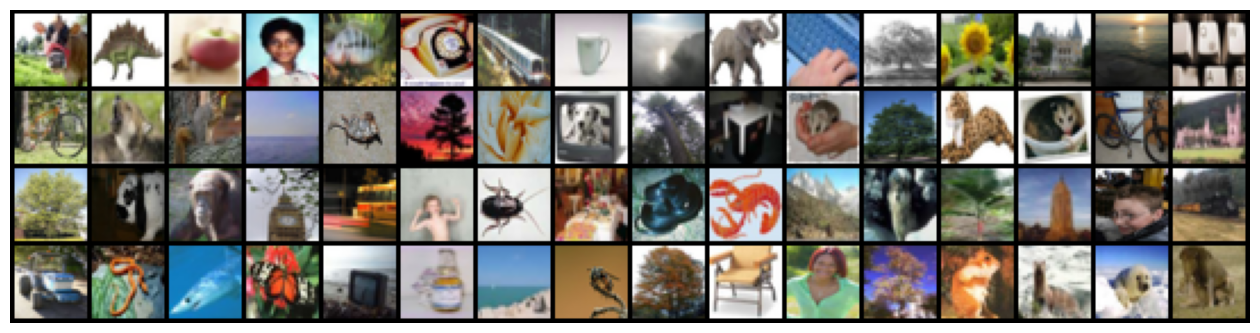

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    print('shape: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [17]:
from torchvision import models

# model = models.resnet18(pretrained=True)
model = torch.load('/mnt/c/phd/experiments/res/effnet_cifar_w4_x_s1.pth')
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [21]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [22]:
epoch_loss_history = []
epoch_acc_history = []

In [25]:
correct = 0
samples = 0

for i, (images, labels) in enumerate(q_test_loader):
    transformed_shape = (4, 27, 27, 3)

    prepared_images = np.transpose(images, (4, 0, 1, 2, 3))
    prepared_images = np.reshape(prepared_images, transformed_shape)
    prepared_images = np.transpose(prepared_images, (0, 3, 1, 2))

    images = transform_test(prepared_images.to(device))
    

    labels = labels.to(device)
    outputs = model(images)
    _, raw_preds = outputs.max(1)

    summed_outputs = outputs.sum(0).unsqueeze(0)

    _, predictions = summed_outputs.max(1)

    predicted = test.classes[predictions.item()]
    actual = test.classes[labels.item()]

    if predicted != actual:
        print(raw_preds.tolist())
        print(f"predicted = {predicted} ({predictions.item()}), actual = {actual} ({labels.item()})")

    correct += (predictions == labels).sum()
    samples += predictions.size(0)

accuracy = float(correct) / float(samples) * 100

print(f"accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")


/home/yevhenii/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[68, 68, 49, 68]
predicted = road (68), actual = mountain (49)
[27, 27, 27, 44]
predicted = crocodile (27), actual = seal (72)
[6, 79, 54, 54]
predicted = orchid (54), actual = tulip (92)
[75, 23, 51, 27]
predicted = cloud (23), actual = butterfly (14)
[71, 71, 23, 71]
predicted = sea (71), actual = cloud (23)
[12, 76, 76, 76]
predicted = skyscraper (76), actual = sea (71)
[79, 38, 79, 76]
predicted = spider (79), actual = dinosaur (29)
[2, 2, 2, 11]
predicted = baby (2), actual = boy (11)
[63, 63, 63, 31]
predicted = elephant (31), actual = porcupine (63)
[24, 76, 76, 76]
predicted = skyscraper (76), actual = cockroach (24)
[75, 65, 65, 99]
predicted = rabbit (65), actual = skunk (75)
[76, 76, 76, 76]
predicted = skyscraper (76), actual = castle (17)
[31, 31, 38, 38]
predicted = elephant (31), actual = camel (15)
[98, 11, 11, 46]
predicted = woman (98), actual = girl (35)
[62, 62, 62, 62]
predicted = poppy (62), actual = sunflower (82)
[67, 67, 49, 67]
predicted = ray (67), actual = f

In [34]:
from collections import Counter

def determine_outcome(probabilities, labels):
    groupped_labels = Counter(labels)
    sorted_groupped = sorted(groupped_labels.items(), key=lambda kv: kv[1], reverse=True)

    if len(sorted_groupped) == 1 or (sorted_groupped[0][1] > sorted_groupped[1][1]):
        return sorted_groupped[0][0]
    else:
        sorted_by_prob = sorted(zip(labels, probabilities), key=lambda lp: lp[1], reverse=True)
        return sorted_by_prob[0][0]



In [35]:
correct = 0
samples = 0

for i, (images, labels) in enumerate(q_test_loader):
    transformed_shape = (4, 27, 27, 3)

    prepared_images = np.transpose(images, (4, 0, 1, 2, 3))
    prepared_images = np.reshape(prepared_images, transformed_shape)
    prepared_images = np.transpose(prepared_images, (0, 3, 1, 2))

    images = transform_test(prepared_images.to(device))

    labels = labels.to(device)
    outputs = model(images)
    probabilities, raw_preds = outputs.max(1)

    # summed_outputs = outputs.sum(0).unsqueeze(0)

    # _, predictions = summed_outputs.max(1)

    prediction = determine_outcome(probabilities.tolist(), raw_preds.tolist())

    actual = labels.item()

    predicted = test.classes[prediction]
    actual = test.classes[actual]

    if predicted != actual:
        print(raw_preds.tolist())
        print(f"predicted = {predicted} ({prediction}), actual = {actual} ({labels.item()})")
    else:
        correct += 1

    samples += 1

accuracy = float(correct) / float(samples) * 100

print(f"accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")


/home/yevhenii/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[68, 68, 49, 68]
predicted = road (68), actual = mountain (49)
[27, 27, 27, 44]
predicted = crocodile (27), actual = seal (72)
[6, 79, 54, 54]
predicted = orchid (54), actual = tulip (92)
[75, 23, 51, 27]
predicted = cloud (23), actual = butterfly (14)
[71, 71, 23, 71]
predicted = sea (71), actual = cloud (23)
[12, 76, 76, 76]
predicted = skyscraper (76), actual = sea (71)
[79, 38, 79, 76]
predicted = spider (79), actual = dinosaur (29)
[2, 2, 2, 11]
predicted = baby (2), actual = boy (11)
[24, 76, 76, 76]
predicted = skyscraper (76), actual = cockroach (24)
[75, 65, 65, 99]
predicted = rabbit (65), actual = skunk (75)
[76, 76, 76, 76]
predicted = skyscraper (76), actual = castle (17)
[31, 31, 38, 38]
predicted = elephant (31), actual = camel (15)
[98, 11, 11, 46]
predicted = boy (11), actual = girl (35)
[62, 62, 62, 62]
predicted = poppy (62), actual = sunflower (82)
[67, 67, 49, 67]
predicted = ray (67), actual = flatfish (32)
[6, 74, 64, 64]
predicted = possum (64), actual = bee (6)

In [27]:
# print(epoch_acc_history)
# with open('/mnt/c/phd/experiments/res/history/resnet_cifar_w4_x_s1_acc_history-2.txt', "w") as f:
#     for item in epoch_acc_history:
#         f.write(f'{item:.5f}\n')

In [28]:
# import pandas as pd

# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
# total_corrects =  0

# classes = set()

# for imgs, labels in test_loader:
#         for i in range(len(labels)):
#                 classes.add(labels[i])

# heatmap = pd.DataFrame(data=0, index=list(classes), columns=list(classes))

# with torch.no_grad():
#         for imgs, labels in test_loader:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)

#                 output = model(imgs)
#                 _, predicted = torch.max(output, 1)


#                 for i in range(labels.size(0)):
#                         if labels[i].item() == predicted[i].item():
#                                 total_corrects += 1
                        
#                         heatmap.iloc[labels[i].item(), predicted[i].item()] += 1

# _, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
# plt.show()

In [29]:
# torch.save(model, '/mnt/c/phd/experiments/res/resnet_cifar_w4_x_s1-2.pth')